In [23]:
# Code done on Google Colab using a GPU
# Data.zip was placed in content
# !unzip "/content/Data.zip"

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split

from sklearn.metrics import precision_score, recall_score, f1_score

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# I. Data Processing

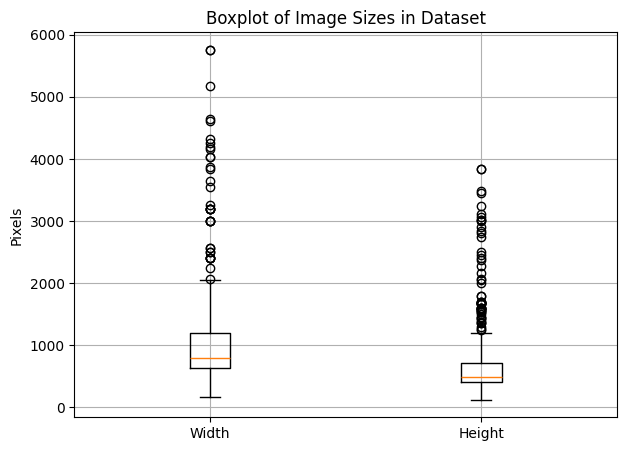

In [14]:
# Boxplot of images' shapes to get an idea
dataset_path = "potholes/"

widths = []
heights = []

# Loop through all subdirectories (class folders)
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)

    if os.path.isdir(class_path):  # Ensure it's a folder
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            # Read image using OpenCV
            image = cv2.imread(image_path)
            if image is not None:
                h, w, _ = image.shape
                widths.append(w)
                heights.append(h)

widths = np.array(widths)
heights = np.array(heights)

plt.figure(figsize=(7, 5))
plt.boxplot([widths, heights], tick_labels=["Width", "Height"])
plt.ylabel("Pixels")
plt.title("Boxplot of Image Sizes in Dataset")
plt.grid(True)
plt.show()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def get_loaders(dataset_path="potholes", size=(256,256), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):

  # Define Image Transformations (Resizing and Normalization)
  transform = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),           # Convert to tensor
      transforms.Normalize(mean,std) # normalize pixel values
  ])

  full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

  train_size = int(0.6 * len(full_dataset))
  val_test_size = len(full_dataset) - train_size
  val_size = val_test_size // 2
  test_size = val_test_size - val_size
  train_dataset, dev_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

  # Create DataLoaders
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

  return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_loaders()
train_loader_resnet, val_loader_resnet, test_loader_resnet = get_loaders(size=(224,224), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # for Resnet50: parameters used in its training

Using device: cuda


# II. Models definition

In [16]:
class PotholeCNN(nn.Module):
    def __init__(self, dropout_value=0.3):
        super(PotholeCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)  # 64 channels * 64 * 64 (64 = 256 / 2 / 2 = 128 / 2: / 2 because of maxpooling)
        self.fc2 = nn.Linear(128, 1)  # Binary classification (pothole or normal)
        self.sigmoid = nn.Sigmoid()  # Activation function for binary classification
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))  # Sigmoid activation for binary output
        return x

In [17]:
import torchvision.models as models
from torchvision.models import ResNet50_Weights

class PotholeResNet50(nn.Module):
    def __init__(self, dropout_value=0.3, pretrained=True):
        super(PotholeResNet50, self).__init__()
        # Pre-trained ResNet50 model
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        # Replace the final fully connected layer for binary classification
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout_value),
            nn.Linear(num_ftrs, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.resnet(x)

# III. Training

In [18]:
def plot_losses(train_losses, dev_losses):
  plt.figure(figsize=(6, 4))
  plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
  plt.plot(range(1, len(dev_losses) + 1), dev_losses, label='Development Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Development Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

In [19]:
def training_CNN(num_epochs, model, train_loader, dev_loader, test_loader, device, dropout_value=0.2, name_model="CNN"):

  print("===============================================================================================")
  print(f"\033[1mTraining {name_model} model with dropout = {dropout_value} \033[0;0m")

  criterion = nn.BCELoss()  # Binary Cross Entropy Loss
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  train_losses = []
  dev_losses = []

  for epoch in range(num_epochs):
      total_loss = 0
      correct = 0
      total = 0

      for images, labels in train_loader:
          images, labels = images.to(device), labels.float().to(device)
          labels = labels.view(-1, 1)  # Reshape labels for BCELoss

          optimizer.zero_grad()  # Reset gradients
          outputs = model(images)  # Forward pass
          loss = criterion(outputs, labels)  # Compute loss
          loss.backward()  # Backpropagation
          optimizer.step()  # Update weights

          total_loss += loss.item()

          predictions = (outputs >= 0.5).float()  # Convert sigmoid outputs to binary (0 or 1)
          correct += (predictions == labels).sum().item()
          total += labels.size(0)

      epoch_loss = total_loss / len(train_loader)
      train_losses.append(epoch_loss)
      epoch_accuracy = correct / total

      # Evaluation on the development set
      model.eval()
      dev_loss = 0
      dev_correct = 0
      dev_total = 0

      with torch.no_grad():
          for images, labels in dev_loader:
              images, labels = images.to(device), labels.float().to(device)
              labels = labels.view(-1, 1)

              outputs = model(images)
              loss = criterion(outputs, labels)
              dev_loss += loss.item()

              predictions = (outputs >= 0.5).float()
              dev_correct += (predictions == labels).sum().item()
              dev_total += labels.size(0)

      dev_epoch_loss = dev_loss / len(dev_loader)
      dev_losses.append(dev_epoch_loss)
      dev_epoch_accuracy = dev_correct / dev_total

      print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {dev_epoch_loss:.4f}, Val Accuracy: {dev_epoch_accuracy:.4f}")


  plot_losses(train_losses, dev_losses)

  torch.save(model.state_dict(), "pothole_cnn.pth")

  # Testing set
  model.eval()
  test_correct = 0
  test_total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.float().to(device)
          labels = labels.view(-1, 1)

          outputs = model(images)
          predictions = (outputs >= 0.5).float()
          test_correct += (predictions == labels).sum().item()
          test_total += labels.size(0)

          all_preds.extend(predictions.view(-1).cpu().numpy())
          all_labels.extend(labels.view(-1).cpu().numpy())

  test_accuracy = test_correct / test_total

  precision = precision_score(all_labels, all_preds)
  recall = recall_score(all_labels, all_preds)
  f1 = f1_score(all_labels, all_preds)

  print(f"\033[1mTest Accuracy: {test_accuracy:.4f}\033[0;0m")
  print(f"\033[1mTest Precision: {precision:.4f}\033[0;0m")
  print(f"\033[1mTest Recall: {recall:.4f}\033[0;0m")
  print(f"\033[1mTest F1-score: {f1:.4f}\033[0;0m")

In [20]:
num_epochs = 10

## CNN

Training CNN model with dropout = 0.2 
Epoch 1/10, Train Loss: 2.2149, Train Accuracy: 0.6593, Val Loss: 0.4508, Val Accuracy: 0.8309
Epoch 2/10, Train Loss: 0.2870, Train Accuracy: 0.9044, Val Loss: 0.5308, Val Accuracy: 0.8015
Epoch 3/10, Train Loss: 0.2630, Train Accuracy: 0.8725, Val Loss: 0.3416, Val Accuracy: 0.8750
Epoch 4/10, Train Loss: 0.1384, Train Accuracy: 0.9510, Val Loss: 0.3538, Val Accuracy: 0.8676
Epoch 5/10, Train Loss: 0.0729, Train Accuracy: 0.9730, Val Loss: 0.4219, Val Accuracy: 0.8603
Epoch 6/10, Train Loss: 0.0358, Train Accuracy: 0.9828, Val Loss: 0.5699, Val Accuracy: 0.8529
Epoch 7/10, Train Loss: 0.0151, Train Accuracy: 1.0000, Val Loss: 0.6452, Val Accuracy: 0.8676
Epoch 8/10, Train Loss: 0.0064, Train Accuracy: 1.0000, Val Loss: 0.6604, Val Accuracy: 0.8309
Epoch 9/10, Train Loss: 0.0028, Train Accuracy: 1.0000, Val Loss: 0.7549, Val Accuracy: 0.8529
Epoch 10/10, Train Loss: 0.0016, Train Accuracy: 1.0000, Val Loss: 0.7629, Val Accuracy: 0.8529


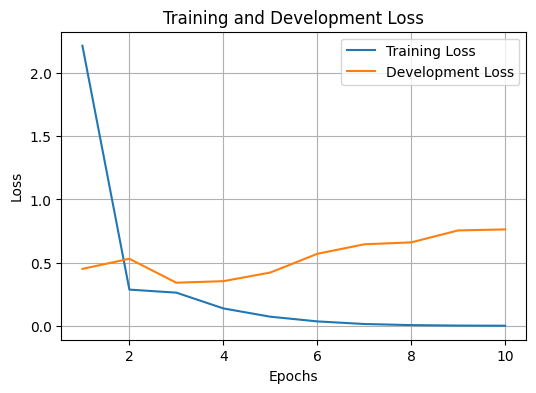

Test Accuracy: 0.8832
Test Precision: 0.8438
Test Recall: 0.9000
Test F1-score: 0.8710
Training CNN model with dropout = 0.3 
Epoch 1/10, Train Loss: 1.7969, Train Accuracy: 0.5931, Val Loss: 0.4825, Val Accuracy: 0.7279
Epoch 2/10, Train Loss: 0.3556, Train Accuracy: 0.8848, Val Loss: 0.3255, Val Accuracy: 0.8603
Epoch 3/10, Train Loss: 0.2222, Train Accuracy: 0.8971, Val Loss: 0.5478, Val Accuracy: 0.8235
Epoch 4/10, Train Loss: 0.2255, Train Accuracy: 0.8971, Val Loss: 0.5249, Val Accuracy: 0.8015
Epoch 5/10, Train Loss: 0.1142, Train Accuracy: 0.9510, Val Loss: 0.4672, Val Accuracy: 0.8750
Epoch 6/10, Train Loss: 0.0646, Train Accuracy: 0.9779, Val Loss: 0.5171, Val Accuracy: 0.8824
Epoch 7/10, Train Loss: 0.0576, Train Accuracy: 0.9755, Val Loss: 0.7386, Val Accuracy: 0.8088
Epoch 8/10, Train Loss: 0.0521, Train Accuracy: 0.9755, Val Loss: 0.4841, Val Accuracy: 0.8750
Epoch 9/10, Train Loss: 0.0131, Train Accuracy: 0.9951, Val Loss: 0.6001, Val Accuracy: 0.8676
Epoch 10/10, Train 

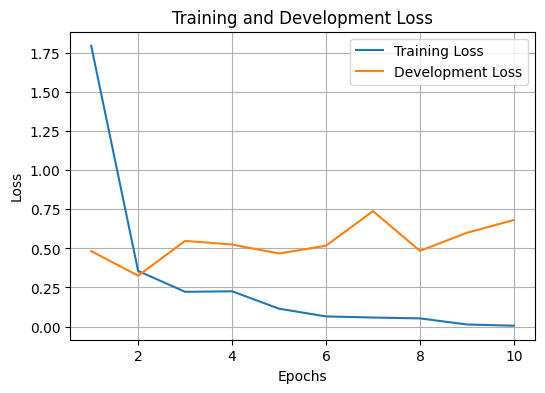

Test Accuracy: 0.8686
Test Precision: 0.7917
Test Recall: 0.9500
Test F1-score: 0.8636
Training CNN model with dropout = 0.4 
Epoch 1/10, Train Loss: 6.0221, Train Accuracy: 0.5172, Val Loss: 0.6321, Val Accuracy: 0.6618
Epoch 2/10, Train Loss: 0.5154, Train Accuracy: 0.7475, Val Loss: 0.5672, Val Accuracy: 0.7721
Epoch 3/10, Train Loss: 0.3113, Train Accuracy: 0.8701, Val Loss: 0.3671, Val Accuracy: 0.8382
Epoch 4/10, Train Loss: 0.1647, Train Accuracy: 0.9314, Val Loss: 0.3186, Val Accuracy: 0.8382
Epoch 5/10, Train Loss: 0.1251, Train Accuracy: 0.9559, Val Loss: 0.3005, Val Accuracy: 0.8603
Epoch 6/10, Train Loss: 0.0739, Train Accuracy: 0.9681, Val Loss: 0.3699, Val Accuracy: 0.8529
Epoch 7/10, Train Loss: 0.0464, Train Accuracy: 0.9877, Val Loss: 0.4590, Val Accuracy: 0.8309
Epoch 8/10, Train Loss: 0.0251, Train Accuracy: 0.9926, Val Loss: 0.7484, Val Accuracy: 0.8529
Epoch 9/10, Train Loss: 0.0438, Train Accuracy: 0.9779, Val Loss: 0.5790, Val Accuracy: 0.8015
Epoch 10/10, Train 

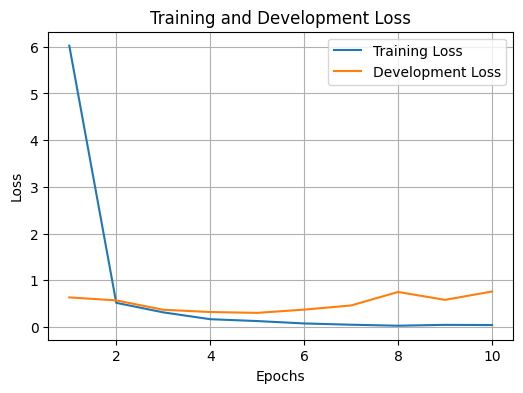

Test Accuracy: 0.8540
Test Precision: 0.7941
Test Recall: 0.9000
Test F1-score: 0.8438


In [21]:
for dropout_value in [0.2, 0.3, 0.4]:
  model = PotholeCNN(dropout_value).to(device)
  training_CNN(num_epochs, model, train_loader, val_loader, test_loader, device, dropout_value)

## Resnet

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]


Training Resnet50 model with dropout = 0.2 
Epoch 1/10, Train Loss: 0.2714, Train Accuracy: 0.8701, Val Loss: 0.8709, Val Accuracy: 0.9559
Epoch 2/10, Train Loss: 40.1202, Train Accuracy: 0.5760, Val Loss: 50.6250, Val Accuracy: 0.4706
Epoch 3/10, Train Loss: 51.2019, Train Accuracy: 0.4902, Val Loss: 50.6250, Val Accuracy: 0.4706
Epoch 4/10, Train Loss: 51.1218, Train Accuracy: 0.4902, Val Loss: 50.6250, Val Accuracy: 0.4706
Epoch 5/10, Train Loss: 51.2821, Train Accuracy: 0.4902, Val Loss: 50.6250, Val Accuracy: 0.4706
Epoch 6/10, Train Loss: 50.9615, Train Accuracy: 0.4902, Val Loss: 50.6250, Val Accuracy: 0.4706
Epoch 7/10, Train Loss: 51.2821, Train Accuracy: 0.4902, Val Loss: 50.6250, Val Accuracy: 0.4706
Epoch 8/10, Train Loss: 50.8814, Train Accuracy: 0.4902, Val Loss: 50.6250, Val Accuracy: 0.4706
Epoch 9/10, Train Loss: 51.1218, Train Accuracy: 0.4902, Val Loss: 50.6250, Val Accuracy: 0.4706
Epoch 10/10, Train Loss: 50.8814, Train Accuracy: 0.4902, Val Loss: 50.6250, Val Accu

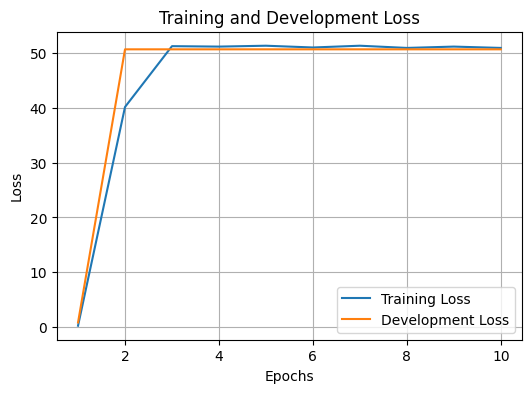

Test Accuracy: 0.4745
Test Precision: 0.4745
Test Recall: 1.0000
Test F1-score: 0.6436
Training Resnet50 model with dropout = 0.3 
Epoch 1/10, Train Loss: 0.2261, Train Accuracy: 0.9240, Val Loss: 0.1748, Val Accuracy: 0.9853
Epoch 2/10, Train Loss: 39.5289, Train Accuracy: 0.6054, Val Loss: 50.6250, Val Accuracy: 0.4706
Epoch 3/10, Train Loss: 51.1218, Train Accuracy: 0.4902, Val Loss: 50.6250, Val Accuracy: 0.4706
Epoch 4/10, Train Loss: 50.8814, Train Accuracy: 0.4902, Val Loss: 50.6250, Val Accuracy: 0.4706
Epoch 5/10, Train Loss: 50.9615, Train Accuracy: 0.4902, Val Loss: 50.6250, Val Accuracy: 0.4706
Epoch 6/10, Train Loss: 50.6410, Train Accuracy: 0.4902, Val Loss: 50.6250, Val Accuracy: 0.4706
Epoch 7/10, Train Loss: 51.4423, Train Accuracy: 0.4902, Val Loss: 50.6250, Val Accuracy: 0.4706
Epoch 8/10, Train Loss: 50.8814, Train Accuracy: 0.4902, Val Loss: 50.6250, Val Accuracy: 0.4706
Epoch 9/10, Train Loss: 51.5224, Train Accuracy: 0.4902, Val Loss: 50.6250, Val Accuracy: 0.470

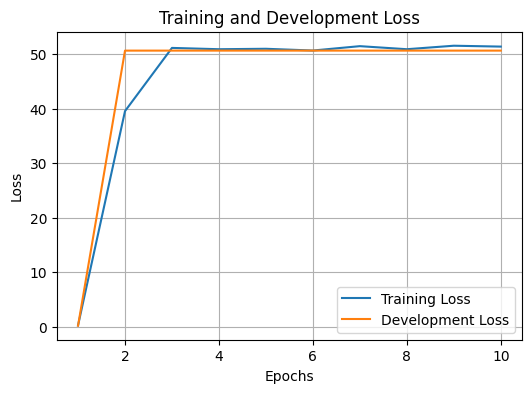

Test Accuracy: 0.4745
Test Precision: 0.4745
Test Recall: 1.0000
Test F1-score: 0.6436
Training Resnet50 model with dropout = 0.4 
Epoch 1/10, Train Loss: 0.2605, Train Accuracy: 0.9167, Val Loss: 0.1018, Val Accuracy: 0.9632
Epoch 2/10, Train Loss: 5.9557, Train Accuracy: 0.5588, Val Loss: 0.9351, Val Accuracy: 0.5294
Epoch 3/10, Train Loss: 0.7589, Train Accuracy: 0.5515, Val Loss: 0.7141, Val Accuracy: 0.4706
Epoch 4/10, Train Loss: 0.6852, Train Accuracy: 0.5466, Val Loss: 0.7165, Val Accuracy: 0.4706
Epoch 5/10, Train Loss: 0.7008, Train Accuracy: 0.5049, Val Loss: 0.6894, Val Accuracy: 0.4706
Epoch 6/10, Train Loss: 0.6915, Train Accuracy: 0.4902, Val Loss: 0.6737, Val Accuracy: 0.7206
Epoch 7/10, Train Loss: 0.6478, Train Accuracy: 0.6887, Val Loss: 2.5680, Val Accuracy: 0.4706
Epoch 8/10, Train Loss: 0.9872, Train Accuracy: 0.6691, Val Loss: 1.2809, Val Accuracy: 0.5882
Epoch 9/10, Train Loss: 0.6737, Train Accuracy: 0.6176, Val Loss: 0.4238, Val Accuracy: 0.8456
Epoch 10/10, T

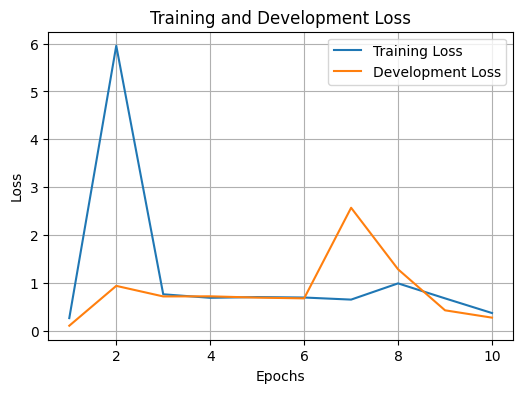

Test Accuracy: 0.9270
Test Precision: 0.9508
Test Recall: 0.8923
Test F1-score: 0.9206


In [22]:
for dropout_value in [0.2, 0.3, 0.4]:
    model = PotholeResNet50(dropout_value=dropout_value).to(device)
    training_CNN(num_epochs, model, train_loader_resnet, val_loader_resnet, test_loader_resnet, device, dropout_value, name_model="Resnet50")